In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Achraf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Achraf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Load the dataset¶


In [3]:
# Load both datasets
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

true_df["text"] = true_df["text"].replace("(Reuters)","",regex=True)
true_df["text"] = true_df["text"].replace("(via)","",regex=True)



## The String "()" still remains in the text column to be removed which i take care of during the NLP part done below
# Add labels: 1 for Fake, 0 for True
fake_df['label'] = 1
true_df['label'] = 0

# Merge the datasets
combined_df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [4]:
# Check for required columns and handle missing ones
required_cols = ['text', 'title', 'subject']

# If 'text' column doesn't exist but 'content' does, rename it
if 'text' not in combined_df.columns and 'content' in combined_df.columns:
    combined_df.rename(columns={'content': 'text'}, inplace=True)

# Ensure we have text content to work with
if 'text' not in combined_df.columns:
    # If no text column, try to use title as text
    if 'title' in combined_df.columns:
        combined_df['text'] = combined_df['title']
    else:
        raise ValueError("Neither 'text' nor 'title' columns found in dataset")

# Drop rows with missing text
combined_df = combined_df.dropna(subset=['text'])

# Shuffle the data
df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

#### Step 2: Data Preprocessing¶


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Initialize resources
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    """
    Comprehensive text cleaning function combining multiple preprocessing techniques.
    """
    # Convert to string and lowercase
    text = str(text).lower()
        
    # Remove special text patterns
    text = re.sub(r'\[.*?\]', '', text)        # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)         # Remove HTML tags
        
    # Remove numbers and words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)       # Remove words containing digits
    text = re.sub(r'\d+', '', text)            # Remove standalone digits
        
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
        
    # Normalize whitespace
    text = re.sub(r'\n', ' ', text)            # Replace newlines with spaces
    text = re.sub(r'\s+', ' ', text).strip()   # Normalize spacing
        
    # Lemmatize and remove stopwords
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
        
    return text

# Fill nulls and combine title and text
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['content'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['content'].apply(clean_text)

#### Step 3: Feature Extraction¶


In [8]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']
print(X)

  (0, 466)	0.19138910675019394
  (0, 4264)	0.4892887121099317
  (0, 631)	0.10811619546682308
  (0, 778)	0.20873539900536692
  (0, 1049)	0.17762697515865114
  (0, 876)	0.08092604974109534
  (0, 1045)	0.20282390476549883
  (0, 962)	0.163113114821308
  (0, 710)	0.15641714680178073
  (0, 4925)	0.16813612379878234
  (0, 3916)	0.03685787866291924
  (0, 3450)	0.08976138409060685
  (0, 4715)	0.07197291874230359
  (0, 171)	0.03605131298896924
  (0, 2105)	0.09505837741723862
  (0, 246)	0.1093114185190954
  (0, 4660)	0.14857177657082055
  (0, 4079)	0.10522536022988967
  (0, 1733)	0.10138085034493888
  (0, 1134)	0.045198106581015626
  (0, 2697)	0.046056628060927744
  (0, 3501)	0.11972708860184872
  (0, 4247)	0.09973631129718012
  (0, 2437)	0.1459835109659171
  (0, 3619)	0.07168677798516972
  :	:
  (44897, 950)	0.04946868604462745
  (44897, 564)	0.06707401069355134
  (44897, 4634)	0.07788658829433423
  (44897, 1354)	0.15764260709259342
  (44897, 1819)	0.21229108890015472
  (44897, 3894)	0.221277806

#### Step 4: Splitting Data


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train)

  (0, 1049)	0.4306353833280148
  (0, 962)	0.03707327462377379
  (0, 3916)	0.01675453576148169
  (0, 171)	0.03277578822406457
  (0, 1134)	0.04109152889608592
  (0, 2437)	0.13271984410355062
  (0, 3400)	0.014540480293975965
  (0, 4641)	0.05898035350083966
  (0, 1594)	0.11946882217831392
  (0, 3118)	0.1372709619255626
  (0, 4608)	0.07439956193004177
  (0, 4854)	0.020273258659824493
  (0, 4245)	0.07691994044342386
  (0, 517)	0.04248974064883666
  (0, 2796)	0.06893142667116665
  (0, 2944)	0.0220565132303476
  (0, 3971)	0.02352645274028012
  (0, 1351)	0.01648438800696332
  (0, 1157)	0.16157291425353434
  (0, 1892)	0.026597894014889722
  (0, 115)	0.05397411597317441
  (0, 3891)	0.04602157798029773
  (0, 729)	0.026646359176229522
  (0, 4961)	0.029214011667410632
  (0, 983)	0.029509813363672092
  :	:
  (35917, 1772)	0.06730751750639347
  (35917, 1757)	0.05899567850716035
  (35917, 4279)	0.07861272631816146
  (35917, 1673)	0.07534759537565662
  (35917, 572)	0.08238380376645527
  (35917, 3706)	0.

In [10]:
import joblib
from pathlib import Path

# Sauvegarde de X_train, X_test, y_train, y_test et tfidf directement avec joblib

joblib.dump(X_train, "X_train.pkl")
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_train,  "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

#### Step 5: Model Training

In [10]:
model = LogisticRegression(penalty='l2', C=0.5)
model.fit(X_train, y_train)

LogisticRegression(C=0.5)

In [11]:
yy = model.predict(X_train)
print(classification_report(y_train, yy))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     17133
           1       0.99      0.98      0.98     18785

    accuracy                           0.98     35918
   macro avg       0.98      0.98      0.98     35918
weighted avg       0.98      0.98      0.98     35918



#### Step 6: Model Evaluation

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4284
           1       0.98      0.97      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



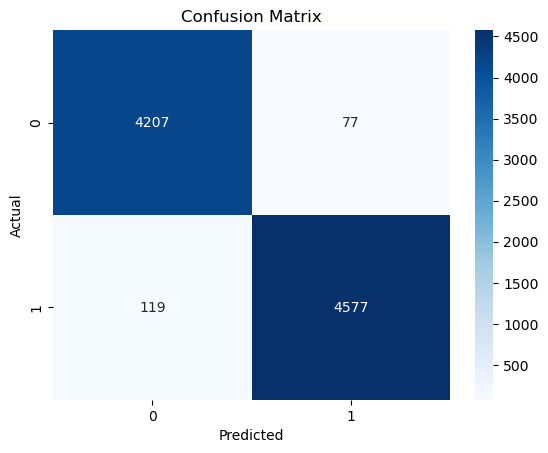

In [12]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### ROC Curve


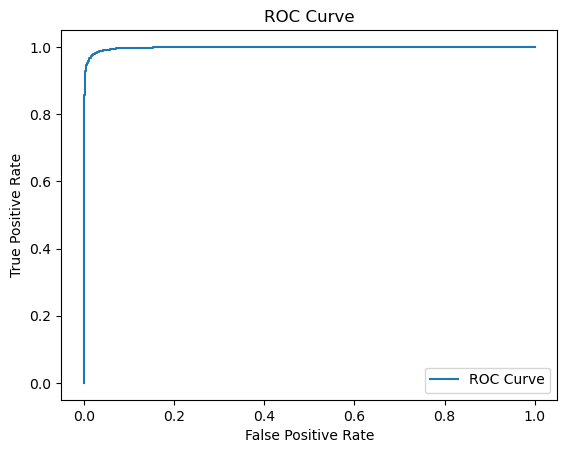

ROC-AUC Score: 0.9978813146496531


In [13]:
probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, probs))

In [14]:
def output_lable(n):
    if n == 1:
        return "Fake News"
    elif n == 0:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(clean_text) 
    new_x_test = new_def_test["text"]
    new_xv_test = tfidf.transform(new_x_test)
    pred_LR = model.predict(new_xv_test)

    return print("\n\nLR Prediction: {}".format(output_lable(pred_LR[0])))

In [24]:
news = str(input())
manual_testing(news)



LR Prediction: Not A Fake News
